# Imports

In [19]:
import pickle
import xgboost as xgb
import shap
import matplotlib.pyplot as plt

In [ ]:
model_path = "pickle/best_model.pkl"
with open(model_path, "rb") as f:
    best_model = pickle.load(f)
print("Model loaded successfully!")

Model loaded successfully!


In [5]:
model_path = "pickle/best_x_train.pkl"
with open(model_path, "rb") as f:
    X_train = pickle.load(f)
print("Model loaded successfully!")

Model loaded successfully!


In [6]:
model_path = "pickle/X_val_data.pkl"
with open(model_path, "rb") as f:
    X_val_data = pickle.load(f)
print("Model loaded successfully!")

model_path = "pickle/y_val_data.pkl"
with open(model_path, "rb") as f:
    y_val_data = pickle.load(f)
print("Model loaded successfully!")

Model loaded successfully!
Model loaded successfully!


# Explanations

In [ ]:
explainer = shap.Explainer(best_model, X_train)
shap_values = explainer(X_val_data)

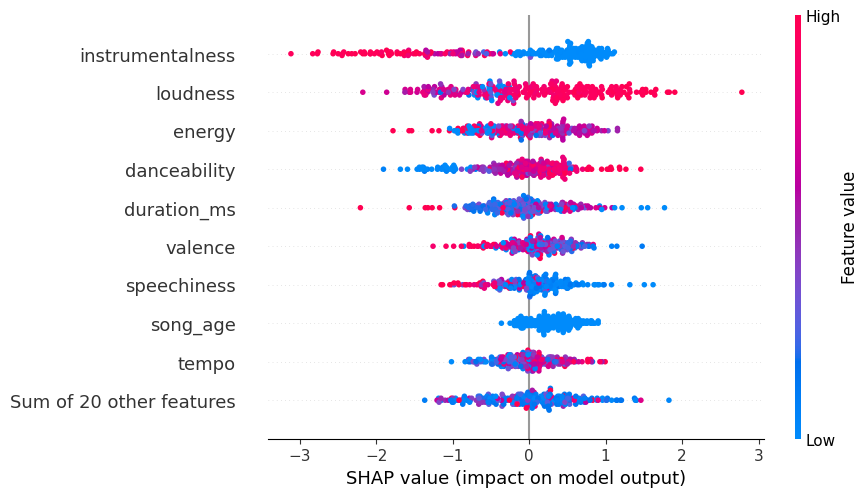

In [20]:
shap.plots.beeswarm(shap_values)
plt.show()

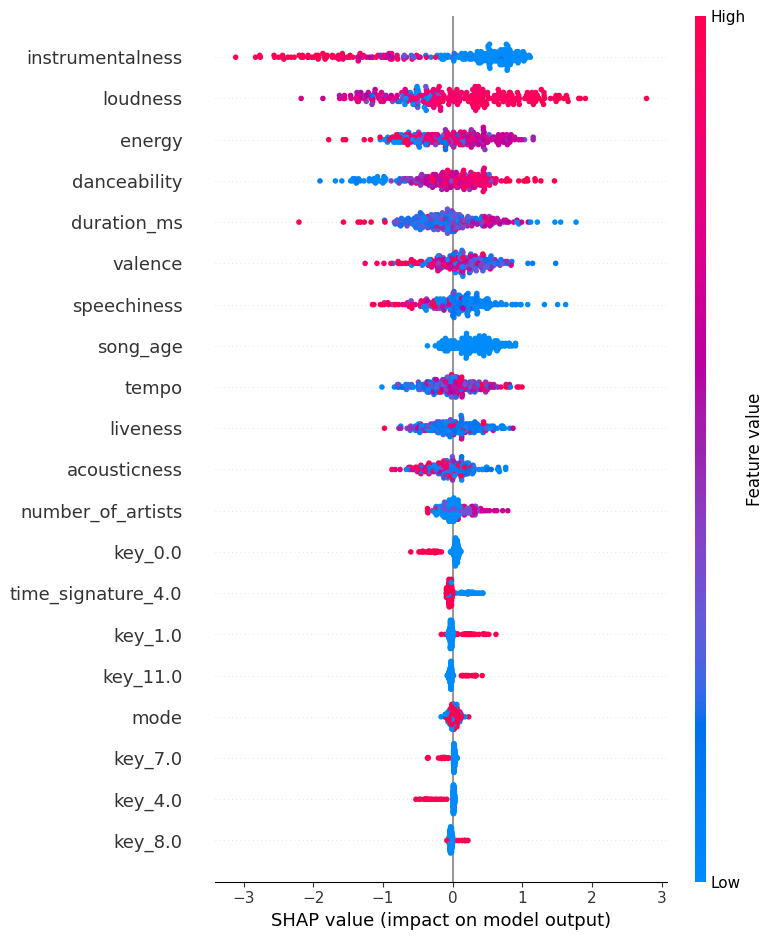

In [22]:
shap.summary_plot(shap_values, X_val_data)

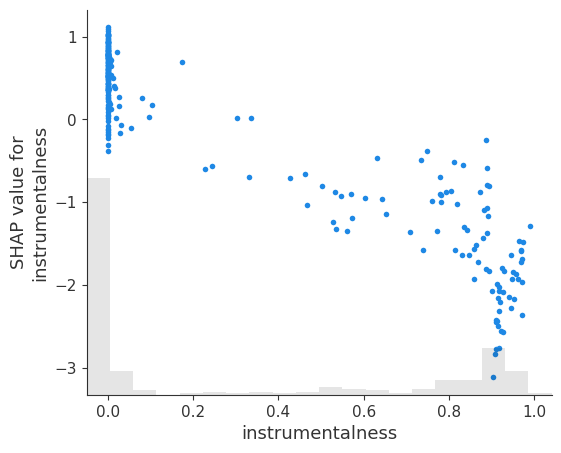

In [24]:
shap.plots.scatter(shap_values[:, "instrumentalness"])

# Logic Explainer

In [33]:
from z3 import *
import numpy as np
set_option(rational_to_decimal=True)


class XGBoostExplainer:
    """Apenas classificação binária e base_score = None
    data = X. labels = y
    """

    def __init__(self, model, data):
        """_summary_

        Args:
            model (XGBoost): xgboost model fited
            data (DataFrame): dataframe (X or X_train)
            labels (array): y (targets)
        """
        self.model = model
        self.data = data.values
        self.columns = model.feature_names_in_.tolist()
        self.max_categories = 2

    def fit(self):
        """Initialize Z3 expressions from model and categoric features from data.
        z3 expressions are built here for pkl compatibility (use fit after export pkl)
        """
        self.categoric_features = self.get_categoric_features(self.data)
        self.T_model = self.model_trees_expression(self.model)
        self.T = self.T_model

    def explain(self, instance, reorder="asc"):
        self.I = self.instance_expression(instance)
        self.D = self.decision_function_expression(self.model, [instance])

        return self.explain_expression(self.I, self.T, self.D, self.model, reorder)

    def get_categoric_features(self, data: np.ndarray):
        """
        Recebe um dataset e retorna uma fórmula no z3 com:
        - Restrições de valor máximo e mínimo para features contínuas.
        - Restrições de igualdade para features categóricas binárias.
        """
        categoric_features = []
        for i in range(data.shape[1]):
            feature_values = data[:, i]
            unique_values = np.unique(feature_values)
            if len(unique_values) <= self.max_categories:
                categoric_features.append(self.columns[i])

        return categoric_features

    def model_trees_expression(self, model):
        """
        Constrói expressões lógicas para todas as árvores de decisão em um dataframe de XGBoost.
        Para árvores que são apenas folhas, gera diretamente um And com o valor da folha.

        Args:
            df (pd.DataFrame): Dataframe contendo informações das árvores.
            class_index (int): Índice da classe atual.

        Returns:
            z3.ExprRef: Fórmula representando todos os caminhos de todas as árvores.
        """
        df = model.get_booster().trees_to_dataframe()
        df["Split"] = df["Split"].round(4)
        self.booster_df = df
        class_index = 0  # if model.n_classes_ == 2:
        all_tree_formulas = []

        for tree_index in df["Tree"].unique():
            tree_df = df[df["Tree"] == tree_index]
            o = Real(f"o_{tree_index}_{class_index}")

            if len(tree_df) == 1 and tree_df.iloc[0]["Feature"] == "Leaf":
                leaf_value = tree_df.iloc[0]["Gain"]
                all_tree_formulas.append(And(o == leaf_value))
                continue
            path_formulas = []

            def get_conditions(node_id):
                conditions = []
                current_node = tree_df[tree_df["ID"] == node_id]
                if current_node.empty:
                    return conditions

                parent_node = tree_df[
                    (tree_df["Yes"] == node_id) | (tree_df["No"] == node_id)
                ]
                if not parent_node.empty:
                    parent_data = parent_node.iloc[0]
                    feature = parent_data["Feature"]
                    split_value = parent_data["Split"]
                    x = Real(feature)
                    if parent_data["Yes"] == node_id:
                        conditions.append(x < split_value)
                    else:
                        conditions.append(x >= split_value)
                    conditions = get_conditions(parent_data["ID"]) + conditions

                return conditions

            for _, node in tree_df[tree_df["Feature"] == "Leaf"].iterrows():
                leaf_value = node["Gain"]
                leaf_id = node["ID"]
                conditions = get_conditions(leaf_id)
                path_formula = And(*conditions)
                implication = Implies(path_formula, o == leaf_value)
                path_formulas.append(implication)

            all_tree_formulas.append(And(*path_formulas))
        return And(*all_tree_formulas)

    def decision_function_expression(self, model, x):
        n_classes = 1 if model.n_classes_ <= 2 else model.n_classes_
        predicted_class = model.predict(x)[0]
        n_estimators = len(model.get_booster().get_dump())

        estimator_pred = Solver()
        estimator_pred.add(self.I)
        estimator_pred.add(self.T)
        variables = [Real(f"o_{i}_0") for i in range(n_estimators)]
        if estimator_pred.check() == sat:
            solvermodel = estimator_pred.model()
            total_sum = sum(
                float(solvermodel.eval(var).as_fraction()) for var in variables
            )
        else:
            total_sum = 0
            print("estimator error")
        init_value = model.predict(x, output_margin=True)[0] - total_sum
        print(init_value)

        equation_list = []
        for class_number in range(n_classes):
            estimator_list = []
            for estimator_number in range(
                int(len(model.get_booster().get_dump()) / n_classes)
            ):
                o = Real(f"o_{estimator_number}_{class_number}")
                estimator_list.append(o)
            equation_o = Sum(estimator_list) + init_value
            equation_list.append(equation_o)

        if n_classes <= 2:
            if predicted_class == 0:
                final_equation = equation_list[0] < 0
            else:
                final_equation = equation_list[0] > 0
        else:
            compare_equation = []
            for class_number in range(n_classes):
                if predicted_class != class_number:
                    compare_equation.append(
                        equation_list[predicted_class] > equation_list[class_number]
                    )
            final_equation = And(compare_equation)

        return final_equation

    def instance_expression(self, instance):
        formula = [Real(self.columns[i]) == value for i, value in enumerate(instance)]
        return formula

    def explain_expression(self, I, T, D, model, reorder):
        i_expression = I.copy()
        T_s = T
        D_s = D

        importances = model.feature_importances_
        non_zero_indices = np.where(importances != 0)[0]

        if reorder == "asc":
            sorted_feature_indices = non_zero_indices[
                np.argsort(importances[non_zero_indices])
            ]
            i_expression = [i_expression[i] for i in sorted_feature_indices]
        elif reorder == "desc":
            sorted_feature_indices = non_zero_indices[
                np.argsort(-importances[non_zero_indices])
            ]
            i_expression = [i_expression[i] for i in sorted_feature_indices]

        for feature in i_expression.copy():

            i_expression.remove(feature)

            # prove(Implies(And(And(i_expression), T), D))
            if self.is_proved(Implies(And(And(i_expression), T_s), D_s)):
                continue
                # print('proved')
            else:
                # print('not proved')
                i_expression.append(feature)
        # print(self.is_proved(Implies(And(And(i_expression), T_s), D_s)))
        return i_expression

    def is_proved(self, f):
        s = Solver()
        s.add(Not(f))
        if s.check() == unsat:
            return True
        else:
            return False

    def delta_expression(self, exp):
        expressions = []
        delta = Real("delta")

        self.delta_features = []
        for name in exp:
            tokens = name.split(" == ")
            z3feature = Real(tokens[0])
            self.delta_features.append(str(z3feature))
            value = tokens[1]

            if tokens[0] in self.categoric_features:
                expressions.append(z3feature == float(value))
            else:
                expressions.append(z3feature >= float(value) - delta)
                expressions.append(z3feature <= float(value) + delta)

        expressions.append(delta >= 0)
        self.deltaexp = expressions
        return expressions

    def get_delta(self, exp):
        expstr = []
        for expression in exp:
            expstr.append(str(expression))
        self.delta_expressions = self.delta_expression(expstr)
        
        opt = Optimize()
        opt.add(self.delta_expressions)
        opt.add(self.T)
        opt.add(Not(self.D))

        delta = Real("delta")
        expmin = opt.minimize(delta)
        opt.check()

        # rangemodel = opt.model()

        value = str(expmin.value())

        if "+ epsilon" in value:
            delta_value = float(value.split(" + ")[0])
        elif "epsilon" == value:
            delta_value = 0
        else:
            delta_value = float(value) - 0.01
        return delta_value

    def explain_range(self, instance, reorder="asc", dataset_bounds=True, ):
        exp = self.explain(instance, reorder)
        if exp != []:
            delta_value = self.get_delta(exp)
            
            if delta_value == 0:
                expstr = []
                for exppart in exp:
                    expstr.append(str(exppart))
                return expstr
            # save_deltas for model comparison

            range_exp = []
            for item in exp:
                name = str(item.arg(0))
                if name not in self.categoric_features:
                    itemvalue = float(item.arg(1).as_fraction())
                    lower = itemvalue - delta_value
                    upper = itemvalue + delta_value

                    if dataset_bounds == True:
                        idx = list(self.columns).index(name)
                        min_idx = np.min(self.data[:, idx])
                        max_idx = np.max(self.data[:, idx])
                        if lower < min_idx:
                            lower = min_idx
                        if upper > max_idx:
                            upper = max_idx

                    range_exp.append(f"{lower} <= {name} <= {upper}")
                else:
                    range_exp.append(f"{name} == {item.arg(1)}")

            return range_exp
        else:
            return exp
        
    def explain_range_other():
        pass

In [34]:
explainer = XGBoostExplainer(best_model, X_train)
explainer.fit()

In [35]:
pred_0 = best_model.predict([X_val_data.values[0]])
pred_18 = best_model.predict([X_val_data.values[18]])

print("0:", pred_0, "18", pred_18)

0: [0] 18 [1]


In [36]:
i = 0
print(explainer.explain(X_val_data.values[i]))
print("delta=", explainer.explain_range(X_val_data.values[i]))

-0.5857043
[valence == 0.157, danceability == 0.555, duration_ms == 290323, key_9.0 == 0, energy == 0.729, acousticness == 0.151, number_of_artists == 1, loudness == -9.798, instrumentalness == 0.867, song_age == 0]
-0.5857043
delta= ['0.166 <= valence <= 0.148', '0.5640000000000001 <= danceability <= 0.546', '290323.009 <= duration_ms <= 290322.991', 'key_9.0 == 0', '0.738 <= energy <= 0.72', '0.16 <= acousticness <= 0.142', '1.009 <= number_of_artists <= 0.991', '-9.789 <= loudness <= -9.807', '0.876 <= instrumentalness <= 0.858', '0.009000000000000001 <= song_age <= -0.009000000000000001']


In [37]:
i = 1
print(explainer.explain(X_val_data.values[i]))
print("delta=", explainer.explain_range(X_val_data.values[i]))

-0.5856999
[tempo == 114.996, liveness == 0.384, valence == 0.607, key_1.0 == 0, danceability == 0.561, duration_ms == 178041, key_9.0 == 0, energy == 0.937, acousticness == 0.0000204, loudness == -5.051, instrumentalness == 0.812, song_age == 0]
-0.5856999
delta= ['115.0031204 <= tempo <= 114.98887959999999', '0.39112040000000003 <= liveness <= 0.3768796', '0.6141204 <= valence <= 0.5998796', 'key_1.0 == 0', '0.5681204000000001 <= danceability <= 0.5538796', '178041.0071204 <= duration_ms <= 178040.9928796', 'key_9.0 == 0', '0.9441204000000001 <= energy <= 0.9298796', '0.007140800000000001 <= acousticness <= -0.0071', '-5.0438796 <= loudness <= -5.0581204', '0.8191204000000001 <= instrumentalness <= 0.8048796', '0.007120400000000001 <= song_age <= -0.007120400000000001']
